In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pathlib
import copy
from sklearn.externals import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from skimage.feature import hog

In [2]:
import os
import struct

"""
Loosely inspired by http://abel.ee.ucla.edu/cvxopt/_downloads/mnist.py
which is GPL licensed.
"""

def read(dataset = "training", path = "."):
    """
    Python function for importing the MNIST data set.  It returns an iterator
    of 2-tuples with the first element being the label and the second element
    being a numpy.uint8 2D array of pixel data for the given image.
    """

    if dataset is "training":
        fname_img = os.path.join(path, 'train-images.idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels.idx1-ubyte')
    elif dataset is "testing":
        fname_img = os.path.join(path, 't10k-images.idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels.idx1-ubyte')
    else:
        raise Exception("dataset must be 'testing' or 'training'")

    # Load everything in some numpy arrays
    with open(fname_lbl, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)

    with open(fname_img, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows, cols)

    get_img = lambda idx: (lbl[idx], img[idx])

    # Create an iterator which returns each image in turn
    for i in range(len(lbl)):
        yield get_img(i)

In [3]:
def train_model(X, Y, model, default_param, param_grid, cv, save, filename):
    """
    Train model using given parameters.
    
    Arguments:
    ------------------------
    - X: training data images
    - Y: training data labels
    - model: estimator class (NOT object)
    - default_param: default parameters you want to apply to model
    - param_grid: used by GridSearchCV
    - cv: k in K-Fold. cross-validation parameter
    - save: whether you save trained model or not
    - filename: path of file to save your model
    
    Returns:
    ------------------------
    - estimator: trained model.
    """
    
    clf = model(**default_param)
    estimator = GridSearchCV(clf, param_grid, cv=cv, n_jobs=-1)
    
    estimator.fit(X, Y)
    
    if save:
        joblib.dump(estimator, filename)
        
    return estimator

def get_model(model, filename, param_grid=dict(), cv=6, X=None, Y=None, default_param=dict(), force_training=False, save=True):
    """
    get model from existing file which has pre-trained model
    or create new model.
    
    Arguments:
    --------------------------
    - model: class of estimator
    - filename: name of file which contains pre-trained model.
    - default_param: default parameters you want to apply to model
    - param_grid: parameters you want to pass to GridSearchCV as parameters of 'param_grid'
    - cv: cross-validation parameter
    - X: training data images
    - Y: training data labels
    - forece_training: if you want this function to ONLY train not load from file, set True.
    - save: if you want to save model after training, set this True.
    
    Returns:
    --------------------------
    - estimator: model trained.
    """
    
    path = pathlib.Path(filename)
    estimator = None
    
    if force_training == True:
        estimator = train_model(X, Y, model, default_param, param_grid, cv, save, filename)
    else:
        if path.exists(): # if file exists, just load that.
            estimator = joblib.load(filename)
        else:
            estimator = train_model(X, Y, model, default_param, param_grid, cv, save, filename)
            
    return estimator

def get_model_without_gridsearch(model, filename, default_param=dict(), X=None, Y=None, save=True):
    """
    Another version of get model without GridSearchCV
    
    Arguments:
    -----------------------------
    model: class name of estimator
    filename: name of file to store our model into.
    default_param: default parameter you want to pass into model.
    X: features of training dataset
    Y: labels of training dataset
    save: if you want to save model after training, set it to True. default: True
    
    Returns:
    -----------------------------
    estimator: model which is trained already.
    """
    
    if pathlib.Path(filename).exists():
        estimator = joblib.load(filename)
    else:
        estimator = model(**default_param)
        estimator.fit(X, Y)
        if save:
            joblib.dump(estimator, filename)
        
    return estimator

In [4]:
def dataset_sampling(images, labels, n_samples=10000):
    """
    Randomly and EQUALLY sampling dataset.
    In this function, all digits have same weights.
    For example, if you passed n_samples as 10000,
    number 0 is to be 1000
    number 1 is to be 1000
    ...
    number 9 is to be 1000
    
    Arguments:
    ------------------------
    images: image dataset to be sampled of size n_samples
    labels: label dataset to be sampled.
    n_samples: sample size.
    
    Returns:
    -------------------------
    result_images: image sampled into n_samples
    result_labels: image sampled into n_samples
    """
    
    # placeholder for sampled dataset.
    result_images = np.zeros((n_samples, 28, 28))
    result_labels = np.zeros((n_samples,))
    
    # sampling
    for i in range(10):
        # to sample all digits equally.
        temp_images = images[labels == i]
        temp_labels = labels[labels == i]
        
        random_index = np.random.randint(0, temp_images.shape[0], size=1000)
        
        result_images[i * 1000 : (i + 1) * 1000] = temp_images[random_index]
        result_labels[i * 1000 : (i + 1) * 1000] = temp_labels[random_index]
        
    return result_images, result_labels

# Read Dataset From Files.

In [5]:
# read dataset fron file.

tr = list(read("training", "data/"))
ts = list(read("testing", 'data/'))

images_train = np.array(list(zip(*tr))[1])
labels_train = np.array(list(zip(*tr))[0])

images_test = np.array(list(zip(*ts))[1])
labels_test = np.array(list(zip(*ts))[0])

print(images_train.shape)
print(labels_train.shape)
print(images_test.shape)
print(labels_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


# Method 1: Using Gradients

In [13]:
def zero_padding(images, n=1):
    """
    zero-padding to image.
    add additional edge which has value of 0
    
    Arguments:
    ---------------------
    - images: training dataset images. maybe (60000, 28, 28)
    - n: how many padding do you want? in other word, how many edge do you want to insert?
    
    Returns:
    ---------------------
    - images_padded: padded images. (60000, 30, 30) or other shape.
    """
    
    # number of training examples. 60000. if you use test data, 10000.
    m = images.shape[0]
    
    # define larger size of window than size of images. maybe (60000, 30, 30), (60000, 32, 32)
    images_padded = np.zeros((m, images.shape[1] + 2 * n, images.shape[2] + 2 * n))
    
    # insert image in the middle of this window.
    images_padded[:, n : images_padded.shape[1] - n, n : images_padded.shape[2] - n] = images
    
    return images_padded

In [14]:
def x_gradient_slice(images_slice):
    """
    find gradient(in korean, 기울기 또는 미분값) for part of images.
    
    Arguments:
    ----------------------
    - images_slice: small window extracted from images. (60000, 7, 7)
    
    Returns:
    ----------------------
    - grad: x-axis-oriented gradient (in korean, x 축 방향 기울기)
    """
    
    x_gradient_filter = np.array([
        [-1,  0,  1],
        [-1,  0,  1],
        [-1,  0,  1],
    ])
    
    # reshape for broadcasting.
    x_gradient_filter = x_gradient_filter.reshape(1, 3, 3)
    
    # element-wise compute. compute gradient
    temp = np.multiply(images_slice, x_gradient_filter)
    grad = np.sum(temp, axis=(1, 2))
    
    return grad

In [15]:
def x_gradient(images):
    """
    find gradient(in korean, 기울기 또는 미분값) for whole images.
    
    Arguments:
    ----------------------
    - images: images. (60000, 28, 28)
    
    Returns:
    ----------------------
    - grad: x-axis-oriented gradient (in korean, x 축 방향 기울기)
    """
    
    # some useful variables.
    m = images.shape[0]
    width = images.shape[1]
    height = images.shape[2]
    
    # define placeholder to store gradients.
    x_grads = np.zeros((m, width - 2, height - 2))
    
    # slice image into small size window, then compute gradient.
    for w in range(1, width - 1):
        for h in range(1, height - 1):
            images_slice = images[:, w - 1 : w + 2, h - 1 : h + 2]
            x_grads[:, w - 1, h - 1] = x_gradient_slice(images_slice)
            
    return x_grads

In [16]:
def y_gradient_slice(images_slice):
    """
    find gradient(in korean, 기울기 또는 미분값) for part of images.
    
    Arguments:
    ----------------------
    - images_slice: small window extracted from images. (60000, 7, 7)
    
    Returns:
    ----------------------
    - grad: y-axis-oriented gradient (in korean, y 축 방향 기울기)
    """
    
    y_gradient_filter = np.array([
        [-1, -1, -1],
        [ 0,  0,  0],
        [ 1,  1,  1],
    ])
    
    # reshape for broadcasting.
    y_gradient_filter = y_gradient_filter.reshape(1, 3, 3)
    
    # element-wise compute. compute gradient
    temp = np.multiply(images_slice, y_gradient_filter)
    grad = np.sum(temp, axis=(1, 2))
    
    return grad

In [17]:
def y_gradient(images):
    """
    find gradient(in korean, 기울기 또는 미분값) for whole images.
    
    Arguments:
    ----------------------
    - images: images. (60000, 28, 28)
    
    Returns:
    ----------------------
    - grad: y-axis-oriented gradient (in korean, y 축 방향 기울기)
    """
    
    # some useful variables.
    m = images.shape[0]
    width = images.shape[1]
    height = images.shape[2]
    
    # define placeholder to store gradients.
    y_grads = np.zeros((m, width - 2, height - 2))
    
    # slice image into small size window, then compute gradient.
    for w in range(1, width - 1):
        for h in range(1, height - 1):
            images_slice = images[:, w - 1 : w + 2, h - 1 : h + 2]
            y_grads[:, w - 1, h - 1] = y_gradient_slice(images_slice)
            
    return y_grads

In [18]:
def get_average_grads(x_grads, y_grads, grid=7):
    """
    After we get gradients, let's compute average of these gradient. I'will post pictures.
    compute partial gradients.
    
    Arguments:
    ---------------------
    - x_grads: pre-computed gradients for x-axis (60000, 28, 28)
    - y_grads: pre-computed gradients for y-axis (60000, 28, 28)
    - grid: grid for dividing images. we will compute average of gradients for each grid. the averages become features.
    
    Returns:
    ---------------------
    - x_avg_grads: average of gradients x-axis (60000, 7, 7)
    - y_avg_grads: average of gradients y-axis (60000, 7, 7)
    """
    
    assert(x_grads.shape == y_grads.shape)
    
    # some useful variables.
    m = x_grads.shape[0]
    width = x_grads.shape[1]
    height = x_grads.shape[2]
    
    # I define these variables to slicing images conveniently.
    w_step = width // grid  # w_step = 4
    h_step = height // grid # h_step = 4
    
    # placeholder for storing average of gradients
    x_avg_grads = np.zeros((m, width // w_step, height // h_step))
    y_avg_grads = np.zeros((m, width // w_step, height // h_step))
    
    for w in range(0, width, w_step):
        for h in range(0, height, h_step):
            # slicing gradients into small part.
            x_grads_slice = x_grads[:, w : w + w_step, h : h + h_step]
            y_grads_slice = y_grads[:, w : w + w_step, h : h + h_step]
            
            assert(x_grads_slice.shape == y_grads_slice.shape == (m, width // grid, height // grid))
            
            # compute mean of gradients of part of image
            x_avg_grads[:, w // w_step, h // h_step] = np.mean(x_grads_slice, axis=(1, 2))
            y_avg_grads[:, w // w_step, h // h_step] = np.mean(y_grads_slice, axis=(1, 2))
            
    return x_avg_grads, y_avg_grads

In [19]:
def average_gradients_grid(images, grid=7, padding=1, normalize=True):
    """
    Preprocessing method 1 which I tried.
    
    Arguments:
    -------------------------
    - images: training or test images (60000, 28, 28)
    - grid: grid for dividing images. we will compute average of gradients for each grid. the averages become features.
    - padding: how much padding image.
    
    Returns:
    -------------------------
    - features: pre-processed features (pixel of images). (60000, 98)
    """
    
    images = np.copy(images)
    
    m = images.shape[0]
    
    # normalize
    if normalize:
        images_norm = images / 255
    else:
        images_norm = images
    
    # thresholding
    images_norm[images_norm >= 0.1] = 1
    images_norm[images_norm < 0.1] = 0
    
    # zero padding
    images_padded = zero_padding(images_norm, padding)
    
    # number of features = grid^2 * 2
    features = np.zeros((m, (grid ** 2) * 2))

    # compute x-axis gradient, y-axis gradient
    x_grads = x_gradient(images_padded)
    y_grads = y_gradient(images_padded)
    
    # compute average of gradient (grid 7x7)
    x_avg_grads, y_avg_grads = get_average_grads(x_grads, y_grads, grid)
    
    assert(x_avg_grads.shape == y_avg_grads.shape == (m, grid, grid))
    
    # flatten
    x_features = x_avg_grads.reshape(m, -1)
    y_features = y_avg_grads.reshape(m, -1)
    
    features[:, : grid ** 2] = x_features
    features[:, grid ** 2 :] = y_features
    
    return features

Okay, let's start! First, we compute gradient features.

In [13]:
preprocessed_1_X_train = average_gradients_grid(images_train)
preprocessed_1_X_test = average_gradients_grid(images_test)

In [14]:
print(preprocessed_1_X_train.shape)
print(preprocessed_1_X_test.shape)

(60000, 98)
(10000, 98)


### CV with un-preprocessed data

In [31]:
X_train, Y_train = dataset_sampling(images_train, labels_train)

In [32]:
print(X_train.shape)
print(Y_train.shape)

(10000, 28, 28)
(10000,)


In [33]:
X_train = X_train.reshape(10000, -1)
X_test = images_test.reshape(10000, -1)

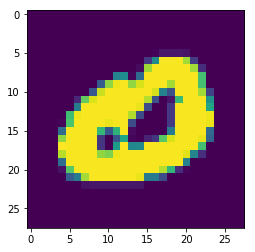

0.0


In [18]:
plt.imshow(X_train.reshape(10000, 28, 28)[3])
plt.show()
print(Y_train[3])

In [34]:
from sklearn.svm import SVC

In [35]:
param_grid = [
    {
        'C': [0.01, 0.1, 1, 10, 100],
        'kernel': ['rbf'],
        'gamma': [0.001, 0.01, 0.1]
    },
    {
        'C': [0.01, 0.1, 1, 10, 100],
        'kernel': ['poly'],
        'gamma': [0.001, 0.01, 0.1],
        'degree': [2, 3]
    }
]

clf_svc = get_model(SVC, 'data/svm.model_data', param_grid=param_grid, cv=5, X=X_train, Y=Y_train)

D:\Users\jylee\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator SVC from version 0.19.1 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\Users\jylee\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator SVC from version 0.19.1 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\Users\jylee\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.19.1 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [36]:
svc=clf_svc.best_estimator_

In [37]:
print('Test Accuracy:', svc.score(X_test, labels_test))

Test Accuracy: 0.9619


## Perceptrons 1

In [16]:
from sklearn.linear_model import Perceptron

In [17]:
# parameters for grid search.
param_grid = [
    {
        'penalty': ['l2', 'l1'],
        'alpha': [1e-7, 1e-5, 1e-3, 1e-1],
        'class_weight': [None, 'balanced']
    },
    {
        'penalty': [None],
        'class_weight': [None, 'balanced']
    }
]

# load or train models.
clf_percp_1_1 = get_model(Perceptron, 'data/perceptron_1.model_data', param_grid, cv=6, X=preprocessed_1_X_train, Y=labels_train)

D:\Users\jylee\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


In [20]:
# get best parameters.
param_percp_1_1 = clf_percp_1_1.best_params_
print(param_percp_1_1)

{'alpha': 1e-05, 'class_weight': None, 'penalty': 'l1'}


In [21]:
# get best perceptron model which was tested on grid search. This contain best parameters.
percp_1_1 = clf_percp_1_1.best_estimator_

# get best accuracy on training set
print('Accuracy on training set:')
print(clf_percp_1_1.best_score_)

# predict accuracy on test set using best perceptron.
print('Accuracy on test set:')
print(percp_1_1.score(preprocessed_1_X_test, labels_test))

Accuracy on training set:
0.8462666666666666
Accuracy on test set:
0.8459


## Logistic Regression 1

In [40]:
from sklearn.linear_model import LogisticRegression

In [41]:
# parameters passed to grid search.
param_grid = [
    {
        'penalty': ['l1', 'l2'],
        'C': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1000], # 1000 means no regularization
        'class_weight': [None, 'balanced'],
    }
]

# load or train model.
clf_logs_1_1 = get_model(LogisticRegression, 'data/logistic_1.model_data', param_grid, 6, X=preprocessed_1_X_train, Y=labels_train, default_param=dict(solver='lbfgs'))

In [43]:
# get and print best hyper parameters
param_logs_1_1 = clf_logs_1_1.best_params_
print(param_logs_1_1)

{'C': 1000, 'class_weight': 'balanced', 'penalty': 'l1'}


In [44]:
# get best logistic regression we found on grid search. This contain best parameters.
logs_1_1 = clf_logs_1_1.best_estimator_

In [45]:
# get best accuracy on training set
print('Accuracy on training set:')
print(clf_logs_1_1.best_score_)

# compute accuracy on test set using best logistic regression
print('Accuracy on test set:')
print(logs_1_1.score(preprocessed_1_X_test, labels_test))

Accuracy on training set:
0.89755
Accuracy on test set:
0.9074


## Support Vector Machine 1

In [46]:
from sklearn.svm import SVC

In [47]:
X_sample_train, Y_sample_train = dataset_sampling(images_train, labels_train)

print(X_sample_train.shape)
print(Y_sample_train.shape)

(10000, 28, 28)
(10000,)


In [48]:
X_svc_grads_train = average_gradients_grid(X_sample_train)
X_svc_grads_test = average_gradients_grid(images_test)

print(X_svc_grads_train.shape)
print(X_svc_grads_test.shape)

(10000, 98)
(10000, 98)


### SVM 1.1

In [49]:
param_grid = [
    {
        'C': [0.01, 0.1, 1, 10, 100],
        'kernel': ['sigmoid', 'rbf'],
        'gamma': ['auto', 'scale', 0.001, 0.01, 0.1]
    },
    {
        'C': [0.01, 0.1, 1, 10, 100],
        'kernel': ['poly'],
        'gamma': ['auto', 'scale', 0.001, 0.01, 0.1],
        'degree': [3, 4, 5]
    }
]

clf_svc_1_1 = get_model(SVC, 'data/svm_1.model_data', param_grid=param_grid, cv=5, X=X_svc_grads_train, Y=Y_sample_train)

In [52]:
params_svm_1_1 = clf_svc_1_1.best_params_
print(params_svm_1_1)

{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}


In [53]:
# get best logistic regression we found on grid search. This contain best parameters.
svm_1_1 = clf_svc_1_1.best_estimator_

In [54]:
# get best accuracy on training set
print('Accuracy on training set:')
print(svm_1_1.score(X_svc_grads_train, Y_sample_train))

# compute accuracy on test set using best logistic regression
print('Accuracy on test set:')
print(svm_1_1.score(X_svc_grads_test, labels_test))

Accuracy on training set:
0.9692
Accuracy on test set:
0.9603


### SVM 1.2

In [57]:
param_grid = [
    {
        'C': [100, 300, 1000, 3000, 10000],
        'kernel': ['rbf'],
        'gamma': [0.1, 0.3, 1.0, 3.0, 10]
    }
]

clf_svm_1_2 = get_model(SVC, 'data/svm_1_2.model_data', param_grid=param_grid, cv=5, X=X_svc_grads_train, Y=Y_sample_train)

In [59]:
param_svm_1_2 = clf_svm_1_2.best_params_
print(param_svm_1_2)

{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}


In [60]:
# get best logistic regression we found on grid search. This contain best parameters.
svm_1_2 = clf_svm_1_2.best_estimator_

In [61]:
# get best accuracy on training set
print('Accuracy on training set:')
print(clf_svm_1_2.best_score_)

# compute accuracy on test set using best logistic regression
print('Accuracy on test set:')
print(svm_1_2.score(X_svc_grads_test, labels_test))

Accuracy on training set:
0.9595
Accuracy on test set:
0.9603


### Getting More Dataset

In [62]:
X_grid_train = average_gradients_grid(images_train)
X_grid_test = average_gradients_grid(images_test)

print(X_grid_train.shape)
print(X_grid_test.shape)

(60000, 98)
(10000, 98)


### SVM 1.3

In [63]:
# if pathlib.Path('data/svm_1_3.model_data').exists():
#     svc_1_3 = joblib.load('data/svm_1_3.model_data')
# else:
#     svc_1_3 = SVC(**params)
#     svc_1_3.fit(X_grid_train, labels_train)
#     joblib.dump(svc_1_3, 'data/svm_1_3.model_data')

param_svm_1_3 = copy.deepcopy(param_svm_1_2)

svm_1_3 = get_model_without_gridsearch(SVC, 'data/svm_1_3.model_data', default_param=param_svm_1_3, X=X_grid_train, Y=labels_train)

In [64]:
print('Accuracy on training set:', svm_1_3.score(X_grid_train, labels_train))
print('Accuracy on test set:', svm_1_3.score(X_grid_test, labels_test))

Accuracy on training set: 1.0
Accuracy on test set: 0.9738


### SVM 1.4

In [65]:
# if pathlib.Path('data/svm_1_4.model_data').exists():
#     svc_1_4 = joblib.load('data/svm_1_4.model_data')
# else:
#     svc_1_4 = SVC(**params)
#     svc_1_4.C = 10
#     svc_1_4.fit(X_grid_train, labels_train)
#     joblib.dump(svc_1_4, 'data/svm_1_4.model_data')

param_svm_1_4 = copy.deepcopy(param_svm_1_3)
param_svm_1_4['C'] = 10

svm_1_4 = get_model_without_gridsearch(SVC, 'data/svm_1_4.model_data', default_param=param_svm_1_4, X=X_grid_train, Y=labels_train)

In [66]:
print('Accuracy on training set:', svm_1_4.score(X_grid_train, labels_train))
print('Accuracy on test set:', svm_1_4.score(X_grid_test, labels_test))

Accuracy on training set: 0.9996
Accuracy on test set: 0.9746


### SVM 1.5

In [67]:
# if pathlib.Path('data/svm_1_5.model_data').exists():
#     svc_1_5 = joblib.load('data/svm_1_5.model_data')
# else:
#     svc_1_5 = SVC(**params)
#     svc_1_5.C = 0.1
#     svc_1_5.fit(X_grid_train, labels_train)
#     joblib.dump(svc_1_5, 'data/svm_1_5.model_data')

param_svm_1_5 = copy.deepcopy(param_svm_1_4)
param_svm_1_5['C'] = 0.3

svm_1_5 = get_model_without_gridsearch(SVC, 'data/svm_1_5.model_data', default_param=param_svm_1_5, X=X_grid_train, Y=labels_train)

In [68]:
print('Accuracy on training set:', svm_1_5.score(X_grid_train, labels_train))
print('Accuracy on test set:', svm_1_5.score(X_grid_test, labels_test))

Accuracy on training set: 0.9784666666666667
Accuracy on test set: 0.9687


### SVM 1.6

In [69]:
param_grid = {
    'C': [0.85, 0.87, 0.90, 0.93, 0.95],
    'kernel': ['rbf'],
    'gamma': [0.1]
}

clf_svm_1_6 = get_model(SVC, 'data/svm_1_6.model_data', param_grid=param_grid, cv=6, X=X_grid_train, Y=labels_train)

In [72]:
param_svm_1_6 = clf_svm_1_6.best_params_
print(param_svm_1_6)

{'C': 0.95, 'gamma': 0.1, 'kernel': 'rbf'}


In [73]:
svm_1_6 = clf_svm_1_6.best_estimator_

In [74]:
print('Accuracy on training dataset: {}'.format(clf_svm_1_6.best_score_))
print('Accuracy on test dataset: {}'.format(svm_1_6.score(X_grid_test, labels_test)))

Accuracy on training dataset: 0.9737833333333333
Accuracy on test dataset: 0.9742


### SVM 1.7

In [75]:
param_grid = {
    'C': [3, 4, 5],
    'kernel': ['rbf'],
    'gamma': [0.1]
}

clf_svm_1_7 = get_model(SVC, 'data/svm_1_7.model_data', param_grid=param_grid, cv=6, X=X_grid_train, Y=labels_train)

In [78]:
param_svm_1_7 = clf_svm_1_7.best_params_
print(param_svm_1_7)

{'C': 5, 'gamma': 0.1, 'kernel': 'rbf'}


In [79]:
svm_1_7 = clf_svm_1_7.best_estimator_

In [80]:
print('Accuracy on training dataset: {}'.format(clf_svm_1_7.best_score_))
print('Accuracy on test dataset: {}'.format(svm_1_7.score(X_grid_test, labels_test)))

Accuracy on training dataset: 0.9760833333333333
Accuracy on test dataset: 0.9747


### SVM 1.8

In [81]:
param_svm_1_8 = copy.deepcopy(param_svm_1_7)
param_svm_1_8['C'] = 7

svm_1_8 = get_model_without_gridsearch(SVC, 'data/svm_1_8.model_data', default_param=param_svm_1_8, X=X_grid_train, Y=labels_train)

In [82]:
print('Accuracy on training set: {}'.format(svm_1_8.score(X_grid_train, labels_train)))
print('Accuracy on test set: {}'.format(svm_1_8.score(X_grid_test, labels_test)))

Accuracy on training set: 0.99935
Accuracy on test set: 0.9741


In [83]:
param_svm_1_9 = copy.deepcopy(param_svm_1_8)
param_svm_1_9['C'] = 6
svm_1_9 = get_model_without_gridsearch(SVC, 'data/svm_1_9.model_data', default_param=param_svm_1_9, X=X_grid_train, Y=labels_train)

In [84]:
print('Accuracy on training set: {}'.format(svm_1_9.score(X_grid_train, labels_train)))
print('Accuracy on test set: {}'.format(svm_1_9.score(X_grid_test, labels_test)))

Accuracy on training set: 0.9991666666666666
Accuracy on test set: 0.9744


In [85]:
param_svm_1_10 = copy.deepcopy(param_svm_1_9)
param_svm_1_10['C'] = 5.25

svm_1_10 = get_model_without_gridsearch(SVC, 'data/svm_1_10.model_data', default_param=param_svm_1_10, X=X_grid_train, Y=labels_train)

In [86]:
print('Accuracy on training set: {}'.format(svm_1_10.score(X_grid_train, labels_train)))
print('Accuracy on test set: {}'.format(svm_1_10.score(X_grid_test, labels_test)))

Accuracy on training set: 0.999
Accuracy on test set: 0.9746


In [87]:
param_svm_1_11 = copy.deepcopy(param_svm_1_10)
param_svm_1_11['C'] = 5.025
svm_1_11 = get_model_without_gridsearch(SVC, 'data/svm_1_11.model_data', default_param=param_svm_1_11, X=X_grid_train, Y=labels_train)

In [88]:
print('Accuracy on training set: {}'.format(svm_1_11.score(X_grid_train, labels_train)))
print('Accuracy on test set: {}'.format(svm_1_11.score(X_grid_test, labels_test)))

Accuracy on training set: 0.9989166666666667
Accuracy on test set: 0.9747


# Method 2: Just Features Reduction

In [6]:
def feature_reduction(images):
    """
    Reduce features.
    
    Operation: For example, look at one pixel in an image.
               If this pixel is one? then, look at neighbors of this pixel. if there are many pixel that has value of 1, then mark this pixel's position as 1.
               If this pixel is zero, then mark this pixel positio as 0
    
    Arguments:
    ---------------------
    - images: training or test image dataset (m, image_size, image_size)
    
    Returns:
    ---------------------
    - reduced: result images after reducing features.
    """
    
    # some useful variable.
    m = images.shape[0]
    width = images.shape[1]
    height = images.shape[2]
    
    # you should mark in this variable.
    reduced = np.zeros((m, width - 2, height - 2))
    
    for i in range(m):
        for w in range(1, width - 1):
            for h in range(1, height - 1):
                if images[i, w, h] == 1:
                    if np.sum(images[i, w - 1 : w + 2, h - 1 : h + 2]) > 3:
                        reduced[i, w - 1, h - 1] = 1
                        
    return reduced

In [7]:
def feature_supression(images):
    """
    In fact, the operation is same as feature_reduction.
    The difference is feature_reduction function don't care about pixel on out-most edge.
    But, this function does care about pixel on out-most edge.
    And, this function use the operation strictly. It make the hand-written-digit more thinner
    
    So, the roll of this function is make the digits image thin.
    
    If you conduct the operation on out-most edge, size of image should not be reduced.
    
    Arguments:
    -------------------------
    - images: training or test image dataset. (m, image_size, image_size)
    
    Returns:
    -------------------------
    - features: image after suppression
    """
    m = images.shape[0]
    width = images.shape[1]
    height = images.shape[2]
    
    features = np.zeros((m, width, height))
    
    for i in range(m):
        for w in range(1, width - 1):
            if images[i, w, 0] == 1:
                count = 0
                if images[i, w - 1, 0] == 1:
                    count += 1
                if images[i, w + 1, 0] == 1:
                    count += 1
                if images[i, w, 1] == 1:
                    count += 1
                
                if count >= 2:
                    features[i, w, 0] = 1
        
        for h in range(1, height - 1):
            if images[i, 0, h] == 1:
                count = 0
                if images[i, 0, h - 1] == 1:
                    count += 1
                if images[i, 0, h + 1] == 1:
                    count += 1
                if images[i, 0, h] == 1:
                    count += 1
                
                if count >= 2:
                    features[i, 0, h] = 1
                    
        for w in range(1, width - 1):
            for h in range(1, height - 1):
                if images[i, w, h] == 1:
                    count = 0
                    if images[i, w - 1, h] == 1:
                        count += 1
                    if images[i, w + 1, h] == 1:
                        count += 1
                    if images[i, w, h - 1] == 1:
                        count += 1
                    if images[i, w, h + 1] == 1:
                        count += 1
                        
                    if count >= 3:
                        features[i, w, h] = 1
                        
    return features

In [8]:
def preprocessing_feature_reduction(images_train, images_test):
    """
    Preprocessing method 2 I tryied
    I mixed feature reduction and suppression.
    
    Arguments
    ----------------------------
    images_train: images in training dataset
    images_test: images in test dataset
    
    Returns
    ---------------------------
    suppressed2_train: result of some feature reductions and suppressions on training dataset
    suppressed2_test: result of some feature reductions and suppressions on test dataset
    cache: middle results in the middle of redunction and suppression.
    """
    
    cache = dict()
    
    images_train[images_train >= 0.1] = 1
    images_train[images_train < 0.1] = 0
    
    images_test[images_test >= 0.1] = 1
    images_test[images_test < 0.1] = 0
    
    reduced1 = feature_reduction(images_train)

    reduced2 = feature_reduction(reduced1)
    suppressed1_train = feature_supression(reduced2)

    reduced3 = feature_reduction(suppressed1_train)
    suppressed2_train = feature_supression(reduced3)


    reduced1_test = feature_reduction(images_test)

    reduced2_test = feature_reduction(reduced1_test)
    suppressed1_test = feature_supression(reduced2_test)

    reduced3_test = feature_reduction(suppressed1_test)
    suppressed2_test = feature_supression(reduced3_test)
    
    cache['reduced1'] = reduced1
    cache['reduced2'] = reduced2
    cache['reduced3'] = reduced3
    cache['suppressed1_train'] = suppressed1_train
    cache['suppressed2_train'] = suppressed2_train
    cache['suppressed1_test'] = suppressed1_test
    cache['suppressed2_test'] = suppressed2_test
    
    return suppressed2_train, suppressed2_test, cache

In [92]:
norm_images_train = images_train / 255
norm_images_test = images_test / 255

In [93]:
suppressed_train, suppressed_test, cache = preprocessing_feature_reduction(norm_images_train, norm_images_test)

Original images: (60000, 28, 28)


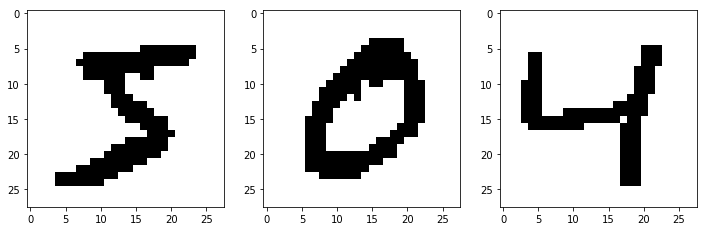

In [94]:
print('Original images: {}'.format(images_train.shape))

plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1)
plt.imshow(1 - norm_images_train[0], cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(1 - norm_images_train[1], cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(1 - norm_images_train[2], cmap='gray')
plt.show()

Image after feature reduction: (60000, 22, 22)
Stage 1: (60000, 26, 26)


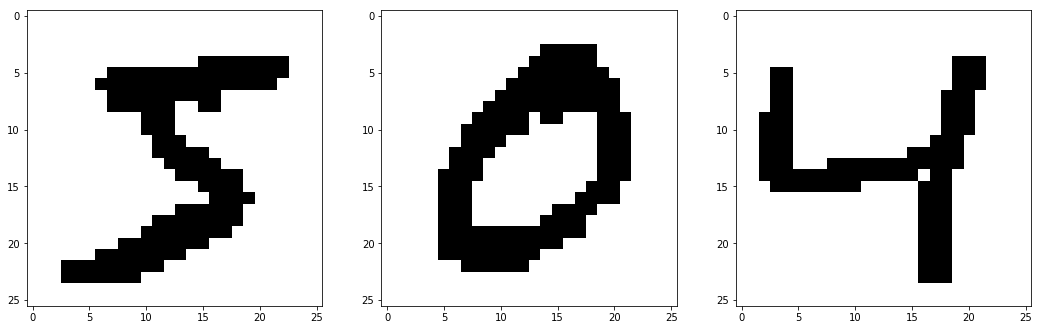

Stage 2: (60000, 24, 24)


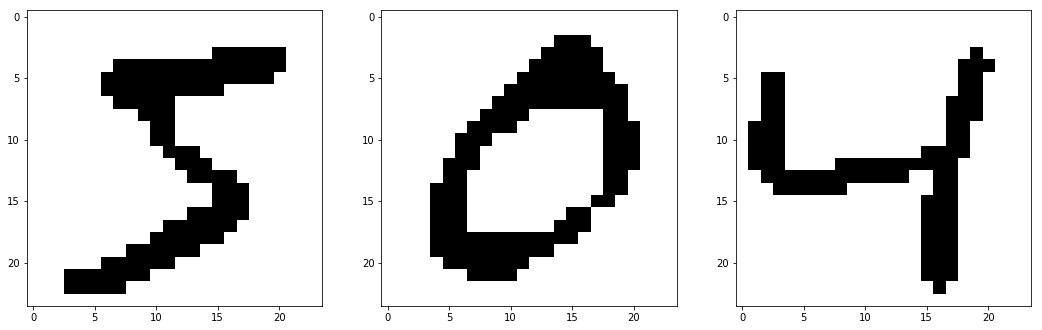

Stage 3: (60000, 22, 22)


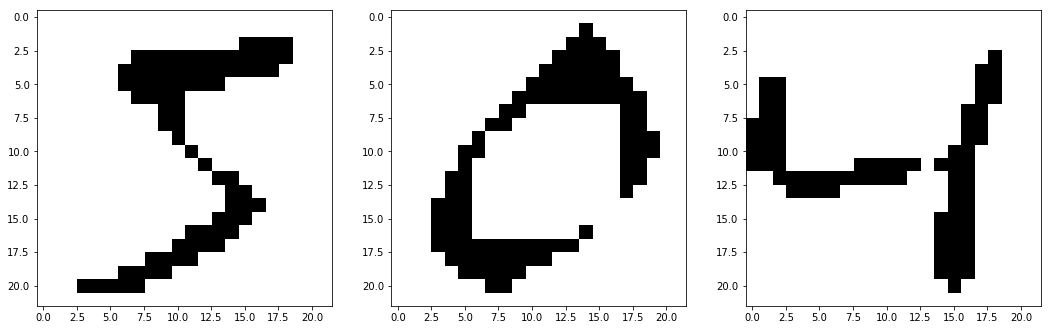

In [95]:
print('Image after feature reduction: {}'.format(suppressed_train.shape))


print('Stage 1: {}'.format(cache['reduced1'].shape))
plt.figure(figsize=(18, 12))
plt.subplot(1, 3, 1)
plt.imshow(1 - cache['reduced1'][0], cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(1 - cache['reduced1'][1], cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(1 - cache['reduced1'][2], cmap='gray')
plt.show()

print('Stage 2: {}'.format(cache['suppressed1_train'].shape))
plt.figure(figsize=(18, 12))
plt.subplot(1, 3, 1)
plt.imshow(1 - cache['suppressed1_train'][0], cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(1 - cache['suppressed1_train'][1], cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(1 - cache['suppressed1_train'][2], cmap='gray')
plt.show()

print('Stage 3: {}'.format(suppressed_train.shape))
plt.figure(figsize=(18, 12))
plt.subplot(1, 3, 1)
plt.imshow(1 - suppressed_train[0], cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(1 - suppressed_train[1], cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(1 - suppressed_train[2], cmap='gray')
plt.show()

## Perceptrons 2

In [96]:
from sklearn.linear_model import Perceptron

In [97]:
# flatten the features.
flatten_train = suppressed_train.reshape(60000, -1)
flatten_test = suppressed_test.reshape(10000, -1)

In [98]:
# paramters for grid search.
param_grid = [
    {
        'penalty': ['l2', 'l1'],
        'alpha': [1e-7, 1e-5, 1e-3, 1e-1],
        'class_weight': [None, 'balanced']
    },
    {
        'penalty': [None],
        'class_weight': [None, 'balanced']
    }
]

clf_percp_2_1 = get_model(Perceptron, 'data/perceptron_2.model_data', param_grid, 6, X=flatten_train, Y=labels_train)

D:\Users\jylee\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator Perceptron from version 0.19.1 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\Users\jylee\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator Perceptron from version 0.19.1 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\Users\jylee\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.19.1 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [101]:
# get best parameters of best perceptron model.
param_percp_2_1 = clf_percp_2_1.best_params_
print(param_percp_2_1)

{'class_weight': None, 'penalty': None}


In [102]:
# get best perceptron which has the highest accuracy during cross validation.
percp_2_1 = clf_percp_2_1.best_estimator_

In [103]:
# get the highest accuracy on training set.
print('Accuracy on training set:')
print(clf_percp_2_1.best_score_)

# compute accuracy on test dataset using best perceptron.
print('Accuracy on test set:')
print(percp_2_1.score(flatten_test, labels_test))

Accuracy on training set:
0.8177
Accuracy on test set:
0.821


## Logistic Regression 2

In [104]:
from sklearn.linear_model import LogisticRegression

In [105]:
# parameters for grid search.
param_grid = [
    {
        'penalty': ['l1', 'l2'],
        'C': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1000],
        'class_weight': [None, 'balanced'],
    }
]

clf_logs_2_1 = get_model(LogisticRegression, 'data/logistic_2.model_data', param_grid, 6, X=flatten_train, Y=labels_train, default_param=dict(solver='lbfgs'))

D:\Users\jylee\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.1 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\Users\jylee\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.1 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\Users\jylee\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.19.1 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [109]:
# get best parameters of best logistic model.
print(clf_logs_2_1.best_params_)

{'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2'}


In [110]:
# get best logistic regression which computed the highest accuracy on training dataset.
logs_2_1 = clf_logs_2_1.best_estimator_

In [111]:
# get best accuracy on training set.
print('Accuracy on training set:')
print(clf_logs_2_1.best_score_)

# compute an accuracy on test set using best logistic regression.
print('Accuracy on test set:')
print(logs_2_1.score(flatten_test, labels_test))

Accuracy on training set:
0.8734
Accuracy on test set:
0.881


## Support Vector Machine 2

In [112]:
X_sample_train, Y_sample_train = dataset_sampling(norm_images_train, labels_train)

print(X_sample_train.shape)
print(Y_sample_train.shape)

(10000, 28, 28)
(10000,)


In [113]:
X_svc_suppressed_train, X_svc_suppressed_test, cache = preprocessing_feature_reduction(X_sample_train, norm_images_test)

print(X_svc_suppressed_train.shape)
print(X_svc_suppressed_test.shape)

(10000, 22, 22)
(10000, 22, 22)


In [114]:
from sklearn.svm import SVC

In [115]:
param_grid = [
    {
        'C': [0.01, 0.1, 1, 10, 100],
        'kernel': ['sigmoid', 'rbf'],
        'gamma': ['auto', 'scale', 0.001, 0.01, 0.1]
    },
    {
        'C': [0.01, 0.1, 1, 10, 100],
        'kernel': ['poly'],
        'gamma': ['auto', 'scale', 0.001, 0.01, 0.1],
        'degree': [3, 4, 5]
    }
]

clf_svm_2_1 = get_model(SVC, 'data/svm_2.model_data', param_grid=param_grid, cv=5, X=X_svc_suppressed_train.reshape(10000, -1), Y=Y_sample_train)

In [117]:
param_svm_2_1 = clf_svm_2_1.best_params_
print(param_svm_2_1)

{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


In [118]:
# get best logistic regression which computed the highest accuracy on training dataset.
svm_2_1 = clf_svm_2_1.best_estimator_

In [119]:
# get best accuracy on training set.
print('Accuracy on training set:')
print(clf_svm_2_1.best_score_)

# compute an accuracy on test set using best logistic regression.
print('Accuracy on test set:')
print(svm_2_1.score(X_svc_suppressed_test.reshape(10000, -1), labels_test))

Accuracy on training set:
0.9355
Accuracy on test set:
0.9337


# Method 3: Fusing Method 1 and Method 2

In [120]:
print(cache['suppressed1_train'].shape)
print(cache['suppressed1_test'].shape)

(10000, 24, 24)
(10000, 24, 24)


In [121]:
fused_train = average_gradients_grid(cache['suppressed1_train'], grid=7, padding=3, normalize=False)
fused_test = average_gradients_grid(cache['suppressed1_test'], grid=7, padding=3, normalize=False)

In [122]:
print(fused_train.shape)
print(fused_test.shape)

(10000, 98)
(10000, 98)


## Perceptrons 3

In [123]:
from sklearn.linear_model import Perceptron

In [124]:
# parameters for grid search.
param_grid = [
    {
        'penalty': ['l2', 'l1'],
        'alpha': [1e-7, 1e-5, 1e-3, 1e-1],
        'class_weight': [None, 'balanced']
    },
    {
        'penalty': [None],
        'class_weight': [None, 'balanced']
    }
]

clf_percp_3_1 = get_model(Perceptron, 'data/perceptron_3.model_data', param_grid, 6, X=fused_train, Y=labels_train)

D:\Users\jylee\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator Perceptron from version 0.19.1 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\Users\jylee\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator Perceptron from version 0.19.1 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\Users\jylee\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.19.1 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [126]:
# get best parameters.
params = clf_percp_3_1.best_params_
print(params)

{'alpha': 1e-07, 'class_weight': None, 'penalty': 'l2'}


In [129]:
# get best perceptron which produced best accuracy on training/valid set.
estimator = clf_percp_3_1.best_estimator_

# get best accuracy on training set
print('Accuracy on training set:')
print(clf_percp_3_1.best_score_)

# compute accuracy on test set using best perceptron.
print('Accuracy on test set:')
print(estimator.score(fused_test, labels_test))

Accuracy on training set:
0.83155
Accuracy on test set:
0.828


## Logistic Regression 3

In [130]:
from sklearn.linear_model import LogisticRegression

In [131]:
# parameters for grid search.
param_grid = [
    {
        'penalty': ['l1', 'l2'],
        'C': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1000],
        'class_weight': [None, 'balanced'],
    }
]

clf_logs_3_1 = get_model(LogisticRegression, 'data/logistic_3.model_data', param_grid, 6, X=fused_train, Y=labels_train, default_param=dict(solver='lbfgs'))

D:\Users\jylee\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.1 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\Users\jylee\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.1 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\Users\jylee\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.19.1 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [136]:
print(clf_logs_3_1.best_params_)

{'C': 1000, 'class_weight': None, 'penalty': 'l2'}


In [137]:
estimator = clf_logs_3_1.best_estimator_

print('Accuracy on training set:')
print(clf_logs_3_1.best_score_)

print('Accuracy on test set:')
print(estimator.score(fused_test, labels_test))

Accuracy on training set:
0.88615
Accuracy on test set:
0.8958


# Method 4: Polynomial Features.

In [9]:
def apply_hog(images_train, images_test):
    m_tr = images_train.shape[0]
    m_ts = images_test.shape[0]
    
    # compute HoG (Historgram of Gradients)
    hog_train = np.zeros((m_tr, 81))
    hog_test = np.zeros((m_ts, 81))
    
    for i in range(m_tr):
        hog_train[i] = hog(images_train[i], block_norm='L2-Hys')
    for i in range(m_ts):
        hog_test[i] = hog(images_test[i], block_norm='L2-Hys')
        
    return hog_train, hog_test

In [10]:
def poly_model(grads, hogs, poly_degree):
    """
    This function reads inputs (grads, hogs) and then append into one vector.
    And, most importantly, make the features (grads + hogs vector) polynomial or exponential
    This has an effect that makes algorithm be applied to non-linear-separatable dataset.
    
    Arguments
    ---------------------------------
    grads: features containing gradients of images
    hogs: features containing histogram of gradients
    
    Returns
    ---------------------------------
    f_train: preprocessed features of training dataset this function generate
    f_test: preprocessed features of test dataset this function generate
    """
    
    # get number of training set (60000), number of test set (10000)
    m_train = grads[0].shape[0] # 60000
    m_test = grads[1].shape[0]  # 10000
    
    # placeholder for new features.
    f_train = np.zeros((m_train, (98 + 81) * poly_degree))
    f_test = np.zeros((m_test, (98 + 81) * poly_degree)) 
    
    grads_train, grads_test = grads[0], grads[1]
    hogs_train, hogs_test = hogs[0], hogs[1]
    
    for i in range(poly_degree):
        f_train[:, (98 + 81) * i : (98 + 81) * i + 98] = grads_train ** (i + 1)
        f_train[:, (98 + 81) * i + 98 : (98 + 81) * (i + 1)] = hogs_train ** (i + 1)
        f_test[:, (98 + 81) * i : (98 + 81) * i + 98] = grads_test ** (i + 1)
        f_test[:, (98 + 81) * i + 98 : (98 + 81) * (i + 1)] = hogs_test ** (i + 1)
        
    return f_train, f_test

In [11]:
def make_poly_features(images_train, images_test, poly_degree=3):
    """
    Arguments
    -------------------------
    images_train: images in training datase shaped of (60000, 28, 28)
    images_test: images in test dataset shaped of (10000, 28, 28)
    poly_degree: how many do you product exponentialy?
    
    Returns
    -------------------------
    f_train: new features preprocessed
    f_test: new features of test images.
    """
    
    m_train = images_train.shape[0]
    m_test = images_test.shape[0]
    
    # compute average of gradients
    avg_grads_train = average_gradients_grid(images_train)
    avg_grads_test = average_gradients_grid(images_test)
    
    hog_train, hog_test = apply_hog(images_train, images_test)
        
    f_train, f_test = poly_model((avg_grads_train, avg_grads_test), (hog_train, hog_test), poly_degree)
    
    return f_train, f_test

In [141]:
poly_train, poly_test = make_poly_features(images_train, images_test)

In [142]:
print(poly_train.shape)
print(poly_test.shape)

(60000, 537)
(10000, 537)


## Perceptron 4

In [143]:
from sklearn.linear_model import Perceptron

In [144]:
param_grid = [
    {
        'penalty': ['l2', 'l1'],
        'alpha': [1e-7, 1e-5, 1e-3, 1e-1],
        'class_weight': [None, 'balanced']
    },
    {
        'penalty': [None],
        'class_weight': [None, 'balanced']
    }
]

clf_percp_4_1 = get_model(Perceptron, 'data/perceptron_4.model_data', param_grid=param_grid, cv=6, X=poly_train, Y=labels_train)

In [145]:
params = clf_percp_4_1.best_params_
print(params)

{'alpha': 1e-05, 'class_weight': 'balanced', 'penalty': 'l1'}


In [146]:
estimator = clf_percp_4_1.best_estimator_

print('Accuracy on training set:')
print(clf_percp_4_1.best_score_)

print('Accuracy on test set:')
print(estimator.score(poly_test, labels_test))

Accuracy on training set:
0.9444666666666667
Accuracy on test set:
0.9567


## Logistic Regression 4

In [147]:
from sklearn.linear_model import LogisticRegression

In [148]:
param_grid = [
    {
        'penalty': ['l1', 'l2'],
        'C': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1000], # 1000 means no regularization
        'class_weight': [None, 'balanced'],
    }
]

clf_logs_4_1 = get_model(LogisticRegression, 'data/logistic_4.model_data', param_grid, 6, X=poly_train, Y=labels_train, default_param=dict(solver='lbfgs'))

In [149]:
params = clf_logs_4_1.best_params_
print(params)

{'C': 1000, 'class_weight': None, 'penalty': 'l2'}


In [150]:
estimator = clf_logs_4_1.best_estimator_

print('Accuracy on training set:')
print(clf_logs_4_1.best_score_)

print('Accuracy on test set:')
print(estimator.score(poly_test, labels_test))

Accuracy on training set:
0.9742833333333333
Accuracy on test set:
0.9761


## Support Vector Machine 4

I tried several svm for different parameters. Since SVM is so slow, I inserted only 10000 dataset for training.

### SVM 4.1

In [151]:
from sklearn.svm import SVC

In [152]:
X_train_sample, Y_train_sample = dataset_sampling(images_train, labels_train)

print(X_train_sample.shape)
print(Y_train_sample.shape)

(10000, 28, 28)
(10000,)


In [153]:
X_poly_train, X_poly_test = make_poly_features(X_train_sample, images_test)

print(X_poly_train.shape)
print(X_poly_test.shape)

(10000, 537)
(10000, 537)


In [154]:
param_grid = [
    {
        'C': [1, 10, 100, 1000],
        'kernel': ['rbf'],
        'gamma': ['auto', 'scale', 0.001, 0.01, 0.1]
    },
    {
        'C': [1, 10, 100, 1000],
        'kernel': ['poly'],
        'gamma': ['auto', 'scale', 0.001, 0.01, 0.1],
        'degree': [1, 2, 3]
    }
]

clf_svm_4_1 = get_model(SVC, 'data/svm_4.model_data', param_grid=param_grid, cv=5, X=X_poly_train, Y=Y_train_sample)

In [155]:
params = clf_svm_4_1.best_params_
print(params)

{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


In [156]:
estimator = clf_svm_4_1.best_estimator_

print('Accuracy on training set:')
print(clf_svm_4_1.best_score_)

print('Accuracy on test set:')
print(estimator.score(X_poly_test, labels_test))

Accuracy on training set:
0.9568
Accuracy on test set:
0.9568


### SVM 4.2

In [157]:
X_poly_train, X_poly_test = make_poly_features(X_train_sample, images_test, poly_degree=1)

print(X_poly_train.shape)
print(X_poly_test.shape)

(10000, 179)
(10000, 179)


In [158]:
param_grid = [
    {
        'C': [1, 10, 100, 1000],
        'kernel': ['rbf'],
        'gamma': ['auto', 'scale', 0.001, 0.01, 0.1]
    },
    {
        'C': [1, 10, 100, 1000],
        'kernel': ['poly'],
        'gamma': ['auto', 'scale', 0.001, 0.01, 0.1],
        'degree': [3, 4, 5]
    }
]

clf_svm_4_2 = get_model(SVC, 'data/svm_4_1.model_data', param_grid=param_grid, cv=5, X=X_poly_train, Y=Y_train_sample)

In [159]:
param = clf_svm_4_2.best_params_
print(param)

{'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}


In [160]:
estimator = clf_svm_4_2.best_estimator_

print('Accuracy on training set:')
print(clf_svm_4_2.best_score_)

print('Accuracy on test set:')
print(estimator.score(X_poly_test, labels_test))

Accuracy on training set:
0.9673
Accuracy on test set:
0.9662


### SVM 4.3

In [20]:
X_train, X_test = make_poly_features(images_train, images_test, poly_degree=1)

In [21]:
if pathlib.Path('data/svm_4_2.model_data').exists():
    svm4 = joblib.load('data/svm_4_2.model_data')
else:
    svm4 = SVC(**param)
    svm4.fit(X_train, labels_train)
    joblib.dump(svm5, 'data/svm_4_2.model_data')

C:\Users\JaeYoungLee\Anaconda3\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator SVC from version 0.20.0 when using version 0.18.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [163]:
print(svm4.score(X_train, labels_train))
print(svm4.score(X_test, labels_test))

0.9992166666666666
0.9817


### SVM 4.4

In [164]:
param_grid = [
    {
        'C': [1, 10, 100, 1000],
        'kernel': ['rbf'],
        'gamma': ['auto', 'scale', 0.001, 0.01, 0.1]
    },
    {
        'C': [1, 10, 100, 1000],
        'kernel': ['poly'],
        'gamma': ['auto', 'scale', 0.001, 0.01, 0.1],
        'degree': [3, 4, 5]
    }
]


svm5 = get_model_without_gridsearch(SVC, 'data/svm_4_3.model_data')
svm5

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [165]:
print(svm5.score(X_train, labels_train))
print(svm5.score(X_test, labels_test))

0.9924166666666666
0.9823


In [166]:
param = dict(C=svm5.C, gamma=svm5.gamma, kernel=svm5.kernel)

In [167]:
param['C'] = 7
svm6 = get_model_without_gridsearch(SVC, 'data/svm_4_9.model_data', default_param=param, X=X_train, Y=labels_train)

print(svm6.score(X_train, labels_train))
print(svm6.score(X_test, labels_test))

0.9903666666666666
0.9815


### SVM 4.5

In [168]:
param_grid = [
    {
        'C': [8.5, 10, 12.5],
        'kernel': ['rbf'],
        'gamma': ['scale']
    }
]

clf_svm_4_5 = get_model(SVC, 'data/svm_4_5.model_data', param_grid=param_grid, cv=5, X=X_poly_train, Y=Y_train_sample)

In [170]:
param = clf_svm_4_5.best_params_
print(param)

print(clf_svm_4_5.best_score_)

{'C': 12.5, 'gamma': 'scale', 'kernel': 'rbf'}
0.9659


In [174]:
param['C'] = 30

svm_4_6 = get_model_without_gridsearch(SVC, 'data/svm_4_6.model_data', default_param=param, X=poly_train, Y=labels_train)

In [172]:
print('Accuracy on training set:', svm_4_6.score(poly_train, labels_train))
print('Accuracy on test set:', svm_4_6.score(poly_test, labels_test))

Accuracy on training set: 0.9945333333333334
Accuracy on test set: 0.9778


In [175]:
param['C'] = 10

svm_4_6 = get_model_without_gridsearch(SVC, 'data/svm_4_7.model_data', default_param=param, X=poly_train, Y=labels_train)

print('Accuracy on training set:', svm_4_6.score(poly_train, labels_train))
print('Accuracy on test set:', svm_4_6.score(poly_test, labels_test))

Accuracy on training set: 0.9920666666666667
Accuracy on test set: 0.9777


In [176]:
param['C'] = 3

svm_4_7 = get_model_without_gridsearch(SVC, 'data/svm_4_8.model_data', default_param=param, X=poly_train, Y=labels_train)

print('Accuracy on training set:', svm_4_7.score(poly_train, labels_train))
print('Accuracy on test set:', svm_4_7.score(poly_test, labels_test))

Accuracy on training set: 0.9815833333333334
Accuracy on test set: 0.9701


# Best Models

## Perceptron: Perceptron 4

In [177]:
from sklearn.linear_model import Perceptron

In [178]:
poly_train, poly_test = make_poly_features(images_train, images_test)

In [179]:
clf = get_model(Perceptron, 'data/perceptron_4.model_data')
percp = clf.best_estimator_

print(percp.score(poly_train, labels_train))
print(percp.score(poly_test, labels_test))

0.95435
0.9567


In [180]:
percp.get_params()

{'alpha': 1e-05,
 'class_weight': 'balanced',
 'early_stopping': False,
 'eta0': 1.0,
 'fit_intercept': True,
 'max_iter': None,
 'n_iter': None,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l1',
 'random_state': 0,
 'shuffle': True,
 'tol': None,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

## Logistic Regression: Logistic Regression 4

In [181]:
from sklearn.linear_model import LogisticRegression

In [182]:
poly_train, poly_test = make_poly_features(images_train, images_test)

In [183]:
clf = get_model(LogisticRegression, 'data/logistic_4.model_data')
logs = clf.best_estimator_

print(logs.score(poly_train, labels_train))
print(logs.score(poly_test, labels_test))

0.98665
0.9761


In [184]:
logs.get_params()

{'C': 1000,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'warn',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'warn',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

## Support Vector Machine: SVM 4.4

In [185]:
from sklearn.svm import SVC

In [186]:
X_train, X_test = make_poly_features(images_train, images_test, poly_degree=1)

In [187]:
svc = get_model_without_gridsearch(SVC, 'data/svm_4_3.model_data')

print(svc.score(X_train, labels_train))
print(svc.score(X_test, labels_test))

0.9924166666666666
0.9823


In [188]:
svc.get_params()

{'C': 10,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [189]:
import sklearn
sklearn.__version__

'0.20.0'